# Problem Set 4 - Structural Estimation

## John Wilson
### July 15, 2017

In [1]:
import numpy as np
import scipy.stats as sts
from scipy.special import gamma, beta
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integrate
%matplotlib notebook

## Problem 3

In [2]:
data = np.loadtxt("data/usincmoms.txt")
midpoints = data[:,1]/1000

### Part a)

<IPython.core.display.Javascript object>


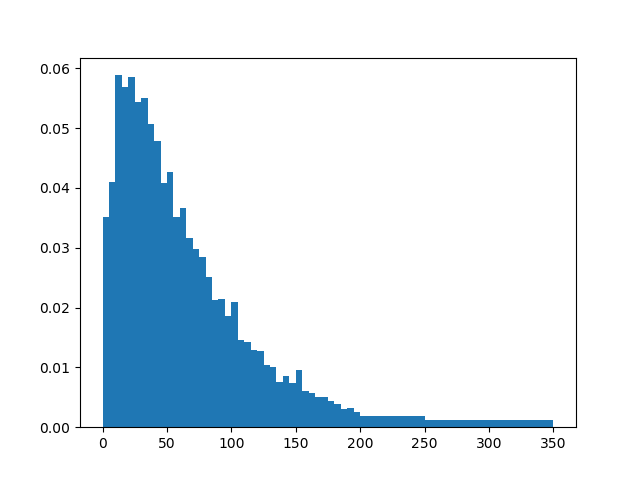

In [3]:
bins = data[:-2,1]/1000 - 2.5
bins=np.append(bins,np.array([200,250,350]))
weights = np.copy(data[:,0])
weights_adj = np.copy(weights)
weights_adj[-2] /= 10
weights_adj[-1] /= 20
vals, bins, fig = plt.hist(data[:,1]/1000,bins = bins, weights = weights_adj)

### Part b)

In [4]:
def get_model_moments(mu, sigma):
    fx = lambda x: sts.lognorm.cdf(x, sigma, scale = np.exp(mu))
    moments = np.empty(len(bins)-1)
    for i in range(len(data)-1):
        moments[i] = fx(bins[i+1]) - fx(bins[i])
    moments[-1] = fx(np.inf) - fx(bins[-2])
    return moments

def error_vec(xvals, mu, sigma):
    m_moments = get_model_moments(mu, sigma)
    return m_moments - xvals

def criterion(params, weights):
    mu, sigma = params
    W = np.diag(weights)
    err = error_vec(weights, mu, sigma)
    crit_val = np.dot(np.dot(err, W), err)
    return crit_val

In [5]:
# Initialize values for mu and sigma starting guesses
mu_init = np.log(np.sum(midpoints * weights))
sigma_init = 5
init_vec = np.array([mu_init, sigma_init])
results = opt.minimize(criterion, init_vec, \
                       args = weights, method = 'L-BFGS-B',\
                       bounds=((1e-10, None), (1e-10, None)))

mu_GMM= 3.90970829092  sigma_GMM= 0.954698944826


<IPython.core.display.Javascript object>


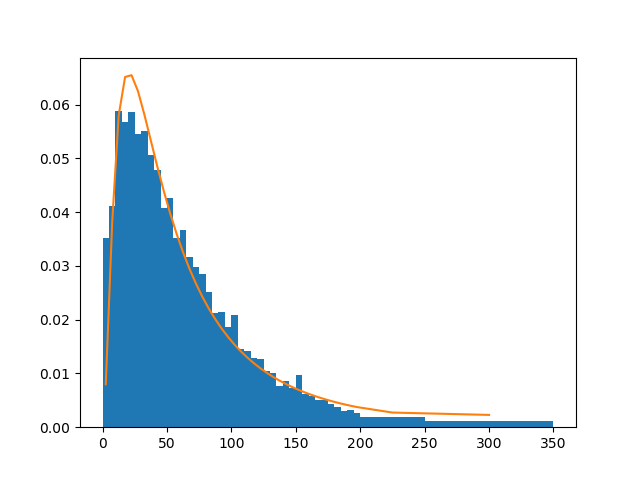

In [7]:
mu_GMM, sigma_GMM = results.x
print("mu_GMM=",mu_GMM, " sigma_GMM=",sigma_GMM)
fx = lambda x: sts.lognorm.cdf(x, sigma_GMM, scale = np.exp(mu_GMM))
moments = np.empty(len(bins)-1)
for i in range(len(data)-1):
    moments[i] = fx(bins[i+1]) - fx(bins[i])
moments[-1] = (fx(np.inf) - fx(bins[-2])) / 20
moments[-2] /= 10
vals, bins, fig = plt.hist(data[:,1]/1000,bins = bins, weights = weights_adj)
plt.plot(midpoints,moments)

### Part c)

In [39]:
def gamma_pdf(xvals, alpha, beta):
    G = gamma(alpha)
    return xvals ** (alpha - 1) * np.exp(-xvals / beta) / (G * beta ** alpha)

def get_model_moments_GA(alpha, beta):
    fx = lambda x: sts.gamma.cdf(x, alpha, scale=beta)
    moments = np.empty(len(bins)-1)
    for i in range(len(data)-1):
        moments[i] = fx(bins[i+1]) - fx(bins[i])
    moments[-1] = fx(np.inf) - fx(bins[-2])
    return moments

def error_vec_GA(xvals, alpha, beta):
    m_moments = get_model_moments_GA(alpha, beta)
    return m_moments - xvals

def criterion_GA(params, weights):
    alpha, beta = params
    print(alpha, beta)
    W = np.diag(weights)
    err = error_vec_GA(weights, alpha, beta)
    crit_val = np.dot(np.dot(err, W), err)
    return crit_val

In [40]:
alpha_init = 6.0
beta_init = 21000.0
init_vec = np.array([alpha_init, beta_init])
results = opt.minimize(criterion_GA, init_vec, \
                       args = weights, method = 'L-BFGS-B',\
                       bounds=((1e-10, None), (1e-10, None)))

6.0 21000.0
6.00000001 21000.0
6.0 21000.0


In [41]:
criterion_GA(init_vec, weights)

6.0 21000.0


0.023789342984261799

In [42]:
np.diag(weights)

array([[ 0.03519016,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.04106206,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.05885948, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.0025767 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01897015,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.02319032]])

0.36787944117144233

0.30326532985631671

0.30326532985631671